# TP N° 3. Redes Neuronales Convolucionales con Keras.
## Trabajo Práctico N° 3

#### **Implementación:** Elegir un problema relacionado con la clasificación de imágenes (puede ser del dataset MNIST o cualquier otro de interés), y desarrollar una solución utilizando CNN con Keras. Implementa el código fuente en Python, asegurándote de incluir el proceso de carga de datos, preprocesamiento, creación del modelo, entrenamiento y evaluación.


En este trabajo se extraerán los gráficos de tiro de Nicolás Laprovittola en su última temporada de Euroliga y se realizarán análisis en base a estos datos. Se realizará de la siguiente manera:

1. Se extraerán los datos de la API de la euroliga.
2. Se preprocesarán los datos para obtener las coordenadas y resultados de los tiros.
3. Se generará un mapa de calor y hexágonos usando los datos extraídos.
4. Se implementará una CNN en Keras que trabaje con el shotchart para hacer predicciones o análisis sobre las zonas de mejor porcentaje.

In [1]:
# Importamos los datos de la API de la euroliga

from euroleague_api.shot_data import ShotData # type: ignore

season = 2023
competition_code = "E"

# Tomamos los datos de la temporada 2023 y del torneo Euroliga

shotdata = ShotData(competition_code)
df = shotdata.get_game_shot_data_single_season(season) # Guardamos los datos en un dataframe
print(df.head())

c:\Users\genaf\anaconda3\Lib\site-packages\euroleague_api\EuroLeagueData.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["played"] = df["played"].replace({"true": True, "false": False})


Season 2023:   0%|          | 0/331 [00:00<?, ?it/s]

   Season Phase  Round  Gamecode  NUM_ANOT TEAM ID_PLAYER              PLAYER  \
0    2023    RS      1         1         4  ASV   P004194  LAUVERGNE, JOFFREY   
1    2023    RS      1         1         6  ASV   P004194  LAUVERGNE, JOFFREY   
2    2023    RS      1         1         7  RED      PLUO       LAZIC, BRANKO   
3    2023    RS      1         1        10  ASV   P004194  LAUVERGNE, JOFFREY   
4    2023    RS      1         1        11  RED   P012711    SIMONOVIC, MARKO   

  ID_ACTION                ACTION  ...  COORD_Y  ZONE  FASTBREAK  \
0      3FGA  Missed Three Pointer  ...      589     I          0   
1      2FGM           Two Pointer  ...      263     E          0   
2      3FGM         Three Pointer  ...      156     I          0   
3      2FGM           Two Pointer  ...      138     C          0   
4      3FGM         Three Pointer  ...      646     I          0   

  SECOND_CHANCE POINTS_OFF_TURNOVER MINUTE CONSOLE  POINTS_A POINTS_B  \
0             0                

In [3]:
df.to_csv('data.csv', index=False) # Guardamos los datos en un .csv

In [4]:
import pandas as pd # type: ignore

# Importamos pandas y tomamos el datafarme del csv

df = pd.read_csv('data.csv')

In [5]:
# Busco al jugador Laprovittola en el dataframe y guardo sus datos en una variable con su nombre
laprovittola = df[df['PLAYER'].str.startswith('LAPROVITTOLA')]
print(laprovittola)

       Season Phase  Round  Gamecode  NUM_ANOT TEAM ID_PLAYER  \
158      2023    RS      1         2        53  BAR   P006435   
170      2023    RS      1         2        86  BAR   P006435   
175      2023    RS      1         2        99  BAR   P006435   
210      2023    RS      1         2       255  BAR   P006435   
212      2023    RS      1         2       272  BAR   P006435   
...       ...   ...    ...       ...       ...  ...       ...   
49252    2023    PO     41       327       476  BAR   P006435   
49253    2023    PO     41       327       477  BAR   P006435   
49254    2023    PO     41       327       481  BAR   P006435   
49255    2023    PO     41       327       483  BAR   P006435   
49258    2023    PO     41       327       504  BAR   P006435   

                      PLAYER ID_ACTION                ACTION  ...  COORD_Y  \
158    LAPROVITTOLA, NICOLAS      3FGM         Three Pointer  ...      740   
170    LAPROVITTOLA, NICOLAS      2FGM           Two Pointer  .

In [6]:
# Guardo dos variables que son los tiros encestados y los tiros fallados

made_shots_mask = laprovittola['ID_ACTION'].str.contains('(2FGM|3FGM)')
made_shots = laprovittola[made_shots_mask]

missed_shots_mask = laprovittola['ID_ACTION'].str.contains('(2FGA|3FGA)') & ~made_shots_mask
missed_shots = laprovittola[missed_shots_mask]

C:\Users\genaf\AppData\Local\Temp\ipykernel_27844\2511944488.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  made_shots_mask = laprovittola['ID_ACTION'].str.contains('(2FGM|3FGM)')
C:\Users\genaf\AppData\Local\Temp\ipykernel_27844\2511944488.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  missed_shots_mask = laprovittola['ID_ACTION'].str.contains('(2FGA|3FGA)') & ~made_shots_mask


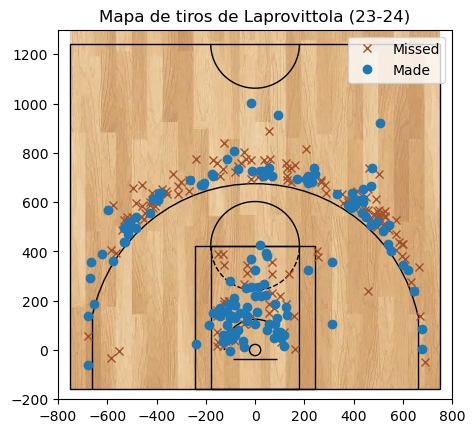

In [7]:
import draw_court, shot_chart_plots

# Importo dos archivos tomados de un repositorio de Github perteneciente al creador de la API para
# hacer los gráficos de tiro

shot_chart_plots.plot_scatter(made_shots, missed_shots, title="Mapa de tiros de Laprovittola (23-24)")

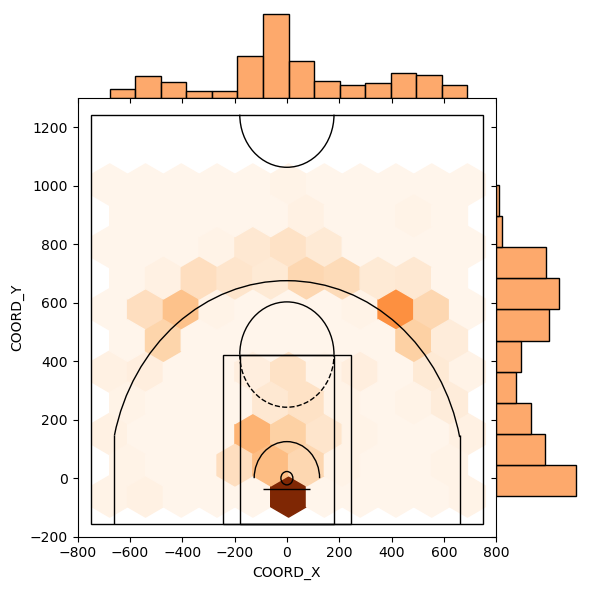

In [8]:
# Grafico las zonas donde más tiros toma (en barras) y sus porcentajes (en los hexágonos)

shot_chart_plots.joint_plot(laprovittola, kind='hex', gridsize=10, title=None, background=False)

In [9]:
# Calculamos la diferencia de puntos entre equipos al momento del lanzamiento
laprovittola.loc[:, 'POINT_DIFF'] = laprovittola['POINTS_A'] - laprovittola['POINTS_B']

# Convertir la columna 'ID_ACTION' en una variable binaria usando .loc
# Si convirtió el lanzamiento, su valor será 1. Si falló, será 0
laprovittola['MADE_SHOT'] = laprovittola['ID_ACTION'].apply(lambda x: 1 if x in ['2FGM', '3FGM'] else 0)

# Seleccionamos las columnas relevantes
features = laprovittola[['COORD_X', 'COORD_Y', 'MINUTE', 'POINT_DIFF']]
target = laprovittola['MADE_SHOT']


C:\Users\genaf\AppData\Local\Temp\ipykernel_27844\1728921336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laprovittola.loc[:, 'POINT_DIFF'] = laprovittola['POINTS_A'] - laprovittola['POINTS_B']
C:\Users\genaf\AppData\Local\Temp\ipykernel_27844\1728921336.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laprovittola['MADE_SHOT'] = laprovittola['ID_ACTION'].apply(lambda x: 1 if x in ['2FGM', '3FGM'] else 0)


In [10]:
# Verificamos la distribución de clases
class_distribution = laprovittola['MADE_SHOT'].value_counts()
print(class_distribution)


MADE_SHOT
0    222
1    138
Name: count, dtype: int64


In [12]:
# Dividimos los datos en conjuntos de prueba y entrenamiento

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [13]:
# Escalamos los datos

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Importamos tensorflow y keras

import tensorflow as tf
from tensorflow.keras import layers, models

# Creamos el modelo de red neuronal
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Clasificación binaria

# Compilamos el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/10


c:\Users\genaf\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6100 - loss: 0.6717 - val_accuracy: 0.6111 - val_loss: 0.6752
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6134 - loss: 0.6701 - val_accuracy: 0.6111 - val_loss: 0.6704
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6575 - loss: 0.6431 - val_accuracy: 0.6111 - val_loss: 0.6689
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6429 - loss: 0.6429 - val_accuracy: 0.6111 - val_loss: 0.6683
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5974 - loss: 0.6557 - val_accuracy: 0.6111 - val_loss: 0.6682
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6395 - loss: 0.6343 - val_accuracy: 0.6250 - val_loss: 0.6684
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6354 - loss: 0.6496 - val_accuracy: 0.6250 - val_loss: 0.6677
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6093 - loss: 0.6561 - val_accuracy: 0.5972 - val_loss: 0.6673
Epoch 9/10
9/9 ━━━

In [15]:
# Evaluamos la precisión del modelo

loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5573 - loss: 0.6759 
Accuracy: 0.5833333134651184


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


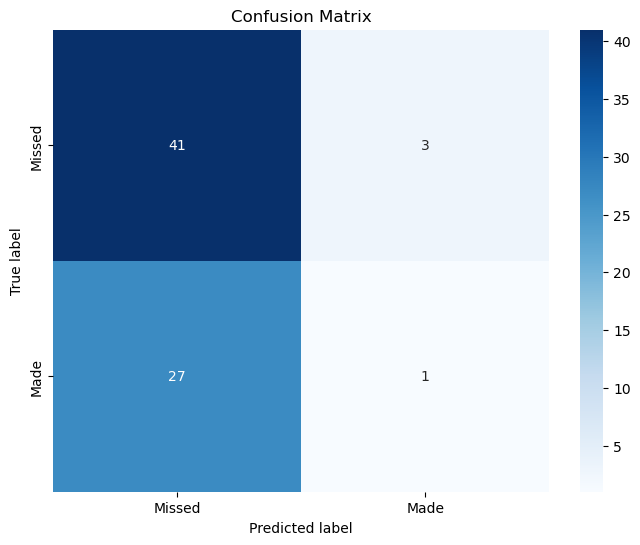

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Realizamos predicciones en el conjunto de prueba
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizamos la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Missed', 'Made'], 
            yticklabels=['Missed', 'Made'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


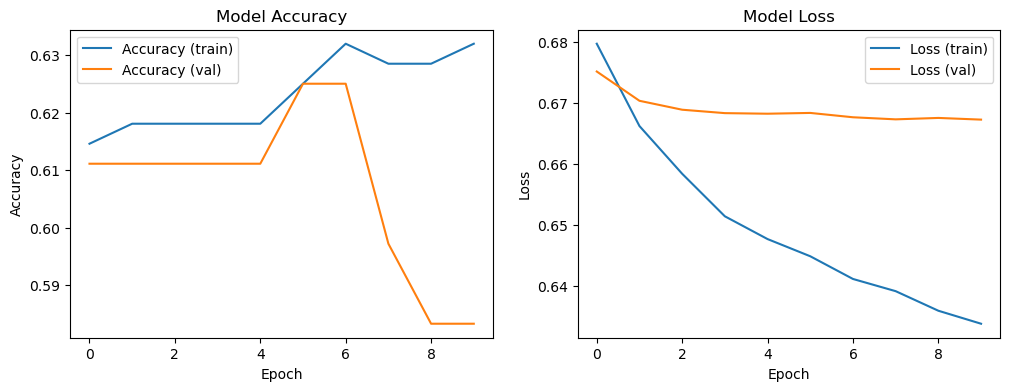

In [17]:
# Graficamos la precisión y pérdida a lo largo de las épocas
plt.figure(figsize=(12, 4))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (val)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


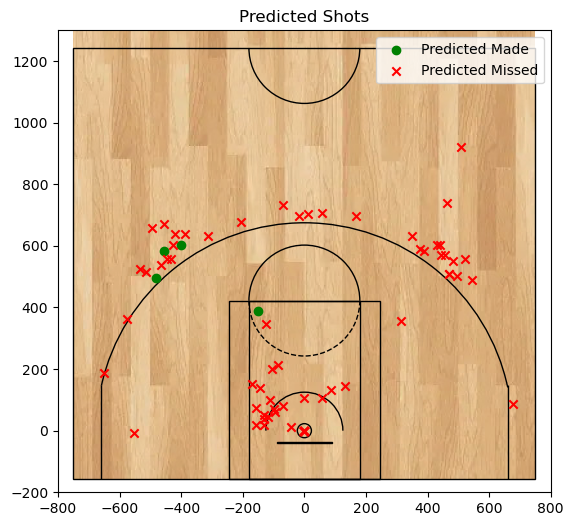

In [18]:
# Creamos un DataFrame para visualizar los tiros con las predicciones
predictions_df = X_test.copy()
predictions_df['PREDICTION'] = y_pred

# Graficamos los tiros reales y las predicciones
plt.figure(figsize=(8, 6))
shot_chart_plots.draw_court()  # Usar tu función de dibujar la cancha
plt.scatter(predictions_df['COORD_X'][predictions_df['PREDICTION'] == 1], 
            predictions_df['COORD_Y'][predictions_df['PREDICTION'] == 1],
            color='green', label='Predicted Made', marker='o')
plt.scatter(predictions_df['COORD_X'][predictions_df['PREDICTION'] == 0], 
            predictions_df['COORD_Y'][predictions_df['PREDICTION'] == 0],
            color='red', label='Predicted Missed', marker='x')

plt.title('Predicted Shots')
plt.xlim([-800, 800])
plt.ylim([-200, 1300])
plt.legend()
plt.show()


#### Conclusión
Pudimos aplicar técnicas de Deep Learning para predecir si los tiros de Nicolás Laprovittola durante la última temporada de la Euroleague entrarían o no, basándonos en diversas variables como la posición en la cancha, el minuto del partido y la diferencia de puntos en el momento del lanzamiento. Utilizamos un enfoque de redes neuronales convolucionales (CNN) implementadas en Keras para realizar las predicciones y analizamos los datos para optimizar el rendimiento del modelo.

Para ello, filtramos y limpiamos el dataset para asegurarnos de que solo se incluyeran los tiros de nuestro jugador a evaluar. Utilizamos las columnas COORD_X, COORD_Y, MINUTE y POINT_DIFF como las principales características para entrenar el modelo, mientras que la columna ID_ACTION fue utilizada para etiquetar los tiros como encestados o fallados.


Entrenamos el modelo utilizando un conjunto de datos dividido entre entrenamiento y prueba, alcanzando una precisión del 58% en las predicciones, lo que muestra un rendimiento regular. Se podría modificar parámetros o sumar estadísticas de otras temporadas del mismo jugador para mejorar nuestro modelo.

Se construyeron gráficos de tiros predichos y se compararon con los resultados reales. Además, se generaron matrices de confusión para evaluar la precisión y el equilibrio del modelo.






